# Antigenic analysis

In [5]:
%matplotlib inline

from Bio.Seq import Seq
from Bio import SeqIO
from Bio.Alphabet import IUPAC
from Bio.Alphabet import generic_dna
import pandas as pd
import os
import tempfile
import sys
import subprocess
from scipy.stats import binom
from ast import literal_eval
from ggplot import *



In [6]:
def write_to_summary(line_pattern,value):
    lines = []
    with open("./results.table.tsv",'r') as results:
        for line in results:
            if line_pattern in line:
                line = line_pattern +"\t" + str(value)+"\n"
            lines.append(line)
            
    with open("./results.table.tsv",'w') as output:
        for l in lines:
            output.write(l)

In [7]:
def Align(headers_seqs, progpath, program='PROBCONS', musclegapopen=None):
    """Performs a multiple sequence alignment of two or more sequences.

    By default, the protein sequences are aligned using PROBCONS.  This is
        probably the most accurate alignment program.  However, it is
        slow and consumes large amounts of memory if you are aligning
        a very large number of sequences (typically if you are aligning
        more than several hundred).  In that case, you may prefer to use
        MUSCLE instead.  You can choose between the two with the 'program'
        option.  If you decide to use MUSCLE, you can also align nucleotide
        sequences with this program.

    'headers_seqs' is a list specifying the names of the sequences that we
        want to align.  Each entry is a 2-tuple '(head, seq)' where 'head' is
        a header giving the sequence name and other information (might be empty)
        and 'seq' is a string giving the protein sequence.  The list must have
        at least 2 entries.

    'progpath' should specify a directory containing the alignment program executable,
        either PROBCONS or MUSCLE.  The PROBCONS executable is assumed to have
        the name "probcons" in this directory.  The MUSCLE executable is assumed to
        have the name "muscle" in this directory.

    'program' specifies what program to use for the alignment.  By default, it is
        "PROBCONS".  If you wish to use MUSCLE instead, set it to "MUSCLE".

    'musclegapopen' sets the MUSCLE gap openining penalty to the specified
        value. By default it is None, meaning we use the MUSCLE default penalty.
        You can also set it to a number; for example -100 will lead to fewer gaps.

    This executable is used to perform a multiple sequence alignment of the proteins
        with the default settings of either PROBCONS or MUSCLE.  The returned variable is a
        new list 'aligned_headers_seqs'.  Each entry is a 2-tuple '(head, aligned_seq)'.
        'head' has the same meaning as on input (the sequence header) and
        'aligned_seq' is the aligned sequence, with gaps inserted as '-'
        as appropriate.  Therefore, all of the 'aligned_seq' entries in
        'aligned_headers_seqs' are of the same length.  The entries in 'aligned_headers_seq'
        are in the same order as in the input list 'headers_seqs'.
    """
    if not (isinstance(headers_seqs, list) and len(headers_seqs) >= 2):
        raise ValueError('header_seqs does not specify a list with at least two entries.')
    if not os.path.isdir(progpath):
        raise ValueError("Cannot find directory %s." % progpath)
    if program == 'PROBCONS':
        exe = os.path.abspath("%s/probcons" % progpath) # the executable
    elif program == 'MUSCLE':
        exe = os.path.abspath("%s/muscle" % progpath) # the executable
    else:
        raise ValueError("Invalid value of %s for 'program'." % (str(program)))
    if not os.path.isfile(exe):
        raise IOError("Cannot find executable at %s." % exe)
    currdir = os.getcwd()
    tempdir = tempfile.mkdtemp()
    try:
        # do stuff in a temporary directory
        infile = "%s/in.fasta" % tempdir # input file
        outfile = "%s/out.fasta" % tempdir # output file
        WriteFASTA(headers_seqs, infile) # write sequences to the input file
        if program == 'PROBCONS':
            p = subprocess.Popen("%s %s" % (exe, infile), shell = True, stdout = subprocess.PIPE, stderr = subprocess.PIPE) # run ProbCons
            (output, errors) = p.communicate()

            open(outfile, 'w').write(output)
        elif program == 'MUSCLE':
            if musclegapopen != None:
                p = subprocess.Popen("%s -gapopen %d -in %s -out %s" % (exe, musclegapopen, infile, outfile), shell = True, stdout = subprocess.PIPE, stderr = subprocess.PIPE) # run MUSCLE
            else:
                p = subprocess.Popen("%s -in %s -out %s" % (exe, infile, outfile), shell = True, stdout = subprocess.PIPE, stderr = subprocess.PIPE) # run MUSCLE
            (output, errors) = p.communicate()
        try:
            aligned_headers_seqs = ReadFASTA(outfile)
        except:
            sys.stderr.write("Error getting alignment output, error of %s" % errors)
            raise
    finally:
        os.chdir(currdir) # return to the original directory
        for file in os.listdir(tempdir):
            os.remove("%s/%s" % (tempdir, file)) # remove files from temporary directory
        os.rmdir(tempdir) # remove temporary directory
    if len(aligned_headers_seqs) != len(headers_seqs):
        raise ValueError("Did not return the correct number of aligned sequences.")
    # put the aligned sequences in the same order as the input sequences
    n = len(aligned_headers_seqs[0][1]) # length of aligned sequences
    d = dict(aligned_headers_seqs)
    aligned_headers_seqs = []
    for (head, seq) in headers_seqs:
        try:
            alignedseq = d[head]
        except KeyError:
            raise ValueError("After alignment, the following header is missing: %s" % head)
        if len(alignedseq) != n:
            open('errors.temp', 'w').write(errors)
            raise ValueError("Aligned sequence %s is not of length %d: if you are using MUSCLE, you may be running out of memory.  Errors have been written to errors.temp." % (alignedseq, n))
        if len(seq) > n:
            open('errors.temp', 'w').write(errors)
            raise ValueError("Unaligned seq %s is longer than aligned length of %d: if you are using MUSCLE, you many be running out of memory.  Errors have been written to errors.temp." % (seq, n))
        aligned_headers_seqs.append((head, alignedseq))
    return aligned_headers_seqs # return the aligned sequences


def StripGapsToFirstSequence(aligned_headers_seqs):
    """Strips gaps from a reference sequence, and all corresponding alignments.

    On input, 'aligned_headers_seqs' should be a set of two or more aligned sequences,
        as would be returned by 'Align'.

    The first sequence in this alignment is taken to correspond to the reference sequence.
        The returned variable is a list similar to aligned_headers_seqs, but with
        all positions corresponding to gaps in this reference sequence stripped away.
        All gaps ('-') characters are removed from this reference sequence.  In addition,
        in all other aligned sequences in 'aligned_headers_seqs', every character at
        the same position as a gap in the reference sequence is removed.  Therefore,
        at the end of this procedure, all of the alignments have the same length
        as the reference sequence with its gaps stripped away.  The headers are
        unchanged.  The order of sequences in this stripped alignment is also
        unchanged.

    >>> StripGapsToFirstSequence([('s1', '-AT-A-GC'), ('s2', 'AAT-TAGC'), ('s3', '--T-A-GC')])
    [('s1', 'ATAGC'), ('s2', 'ATTGC'), ('s3', '-TAGC')]
    """
    if not (isinstance(aligned_headers_seqs, list) and len(aligned_headers_seqs) >= 2):
        raise ValueError("aligned_headers_seqs does not specify at least two aligned sequences.")
    (ref_head, ref_seq) = aligned_headers_seqs[0]
    non_strip_positions = [] # positions not to strip away
    stripped_ref_seq = []
    for i in range(len(ref_seq)):
        r = ref_seq[i]
        if r != '-':
            non_strip_positions.append(i)
            stripped_ref_seq.append(r)
    stripped_headers_seqs = [(ref_head, ''.join(stripped_ref_seq))]
    for (ihead, iseq) in aligned_headers_seqs[1 : ]:
        istrippedseq = ''.join([iseq[i] for i in non_strip_positions])
        stripped_headers_seqs.append((ihead, istrippedseq))
    return stripped_headers_seqs


def WriteFASTA(headers_seqs, filename, writable_file=False):
    """Writes sequences to a FASTA file.

    'headers_seqs' is a list of 2-tuples specifying sequences and their
        corresponding headers.  Each entry is the 2-tuple '(header, seq)'
        where 'header' is a string giving the header (without the leading ">"),
        and 'seq' is the corresponding sequence.

    'filename' is a string that specifies the name of the file to which the
        headers and sequences should be written.  If this file already exists,
        it is overwritten.

    'writable_file' is a Boolean switch specifying that rather than 'filename'
        giving a string specifying the name of a file to which the sequences
        should be written, it instead specifies a writable file object to which
        the sequences should be written.

    The sequences are written to the file in the same order that they are specified
        in 'headers_seqs'.
    """
    assert isinstance(writable_file, bool)
    if writable_file:
        f = filename
    else:
        f = open(filename, 'w')
    for (header, seq) in headers_seqs:
        f.write(">%s\n%s\n" % (header, seq))
    if not writable_file:
        f.close()



def ReadFASTA(fastafile):
    """Reads sequences from a FASTA file.

    'fastafile' should specify the name of a FASTA file.

    This function reads all sequences from the FASTA file.  It returns the
        list 'headers_seqs'.  This list is composed of a 2-tuple '(header, seq)'
        for every sequence entry in FASTA file.  'header' is the header for
        a sequence, with the leading ">" and any trailing spaces removed. 'seq'
        is the corresponding sequence.
    """
    lines = open(fastafile).readlines()
    headers_seqs = []
    header = None
    seq = []
    for line in lines:
        if line[0] == '>':
            if (not header) and (not seq):
                pass # first sequence in file
            elif header and not seq:
                raise ValueError("Empty sequence for %s" % header)
            elif seq and not header:
                raise ValueError("File does not begin with header.")
            else:
                seq = ''.join(seq)
                seq = seq.replace(' ', '')
                headers_seqs.append((header, seq))
            header = line.strip()[1 : ]
            seq = []
        else:
            seq.append(line.strip())
    if (not header) and (not seq):
        pass # first sequence in file
    elif header and not seq:
        raise ValueError("Empty sequence for %s" % header)
    elif seq and not header:
        raise ValueError("File does not begin with header.")
    else:
        seq = ''.join(seq)
        seq = seq.replace(' ', '')
        headers_seqs.append((header, seq))
    return headers_seqs


def GetCorrespondingResidue(seqs, i):
    """Gets the corresponding residue number for two aligned sequences.

    *seqs* is a set of two aligned sequences as *(head, sequence)* 2-tuples.

    *i* is the number of a residue in sequential numbering of *seqs[0]*
    without considering any of the gaps induced by alignment, in 1, 2, ...
    numbering.

    Returns the number of the residue in sequential numbering of *seqs[1]*
    without considering any of the gaps induced by alignment in 1, 2, ...
    numbering. Returns *None* if residue *i* of *seqs[0]* aligns with a
    gap in *seqs[1]*.
    """
    assert len(seqs) == 2
    s1 = seqs[0][1]
    s2 = seqs[1][1]
    assert len(s1) == len(s2)
    assert 1 <= i <= len(s1)
    s1index = s2index = 0
    for j in range(len(s1)):
        if s1[j] != '-':
            s1index += 1
        if s2[j] != '-':
            s2index += 1
        if s1index == i:
            if s2[j] == '-':
                return None
            else:
                return s2index


def find_aligments(aligner,aligner_path,seq,pos): # The positions will be given as base 0 and adjusted to match the convention (base 1) in the funciton
    """Main body of script."""
    print("\nBeginning execution of HA_numbering script.")

    # parse arguments
    if aligner == 'probcons':
        alignerpath = aligner_path # redundant
        if not os.path.isdir(alignerpath):
            raise IOError("The directory of %s specified by probconspath does not exist." % (alignerpath))
        prog = 'PROBCONS'
    elif aligner == 'muscle':
        alignerpath = aligner_path # redundant
        if not os.path.isdir(alignerpath):
            raise IOError("The directory of %s specified by musclepath does not exist." % (alignerpath))
        prog = 'MUSCLE'
    else:
        raise IOError("First argument does not specify probcons or muscle")
    ha_sequence = str(seq) # just get the sequence
    sites = pos
    # Define sequences and their numbering conversions.
    # The sequences are in seq_d and keyed by PDB code.
    # The number conversions from sequential numbering of these sequences to
    # th number labels are in label_d and keyed by PDB codes.
    seq_names = ['4HMG', '4JTV']
    seq_d = {}
    label_d = {}
    seq_4hmg_a = \
        'QDLPGNDNSTATLCLGHHAVPNGTLVKTITDDQIEVTNATELVQSSSTGKICNNPHRILDGIDCTLIDALLGDPHCDVFQ' +\
        'NETWDLFVERSKAFSNCYPYDVPDYASLRSLVASSGTLEFITEGFTWTGVTQNGGSNACKRGPGSGFFSRLNWLTKSGST' +\
        'YPVLNVTMPNNDNFDKLYIWGIHHPSTNQEQTSLYVQASGRVTVSTRRSQQTIIPNIGSRPWVRGQSSRISIYWTIVKPG' +\
        'DVLVINSNGNLIAPRGYFKMRTGKSSIMRSDAPIDTCISECITPNGSIPNDKPFQNVNKITYGACPKYVKQNTLKLATGM' +\
        'RNVPEKQT'
    seq_4hmg_b = \
        'GLFGAIAGFIENGWEGMIDGWYGFRHQNSEGTGQAADLKSTQAAIDQINGKLNRVIEKTNEKFHQIEKEFSEVEGRIQDL' +\
        'EKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTRRQLRENAEEMGNGCFKIYHKCDNACIESIRNGTYDHD' +\
        'VYRDEALNNRFQIKG'
    seq_d['4HMG'] = seq_4hmg_a + seq_4hmg_b
    label_d['4HMG'] = dict([(i + 1, '%d in HA1' % (i + 1)) for i in range(len(seq_4hmg_a))] + [(len(seq_4hmg_a) + i + 1, '%d in HA2' % (i + 1)) for i in range(len(seq_4hmg_b))])
    assert len(seq_d['4HMG']) == len(label_d['4HMG'])
    seq_4jtv_a = \
        'DTLCIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDKHNGKLCKLRGVAPLHLGKCNIAGWILGNPECESLSTASSWSYIV' +\
        'ETPSSDNGTCYPGDFIDYEELREQLSSVSSFERFEIFPKTSSWPNHDSNKGVTAACPHAGAKSFYKNLIWLVKKGNSYPK' +\
        'LSKSYINDKGKEVLVLWGIHHPSTSADQQSLYQNADTYVFVGSSRYSKKFKPEIAIRPKVRDQEGRMNYYWTLVEPGDKI' +\
        'TFEATGNLVVPRYAFAMERNAGSGIIISDTPVHDCNTTCQTPKGAINTSLPFQNIHPITIGKCPKYVKSTKLRLATGLRN' +\
        'I'
    seq_4jtv_b = \
        'GLFGAIAGFIEGGWTGMVDGWYGYHHQNEQGSGYAADLKSTQNAIDEITNKVNSVIEKMNTQFTAVGKEFNHLEKRIENL' +\
        'NKKVDDGFLDIWTYNAELLVLLENERTLDYHDSNVKNLYEKVRSQLKNNAKEIGNGCFEFYHKCDNTCMESVKNGTYDYP' +\
        'KY'
    seq_d['4JTV'] = seq_4jtv_a + seq_4jtv_b
    label_d['4JTV'] = dict([(i + 1, '%d of HA1' % (i + 7)) for i in range(len(seq_4jtv_a))] + [(len(seq_4jtv_a) + i + 1, '%d of HA2' % (i + 1)) for i in range(len(seq_4jtv_b))])
    assert len(seq_d['4JTV']) == len(label_d['4JTV'])

    # make alignments
    print("Making %s alignments..." % prog)
    alignments = {}
    for seqname in seq_names:
        alignments[seqname] = Align([('seq', ha_sequence), (seqname, seq_d[seqname])], alignerpath, prog)
    print("Alignments complete.\n\nHere are the corresponding residue numbers:")
    #print(sites)
    out_hmg=[]
    out_jtv = []
    for site in sites:
        #site=site+1 # to correct for difference in base numbering
        if not (1 <= site <= len(ha_sequence)):
            raise ValueError("site %d is outside the valid range for sequential numbering of ha_sequence starting at 1." % site)
        sitestring = ['\nResidue %s%d in sequential numbering of your HA sequence corresponds to:' % (ha_sequence[site - 1], site)]
        for seqname in seq_names:
            i = GetCorrespondingResidue(alignments[seqname], site)
            if i == None:
                sitestring.append('  * an alignment gap in %s' % seqname)
            else:
                if not (1 <= i <= len(seq_d[seqname])):
                    raise ValueError("Invalid corrresponding residue for %s -- something is wrong with this program" % seqname)
                aa = seq_d[seqname][i - 1]

                sitestring.append('  * %s%s in %s' % (aa, label_d[seqname][i], seqname))
        print( '\n'.join(sitestring))
        out_hmg.append(sitestring[1][4:-7])
        out_jtv.append(sitestring[2][4:-7])
    
    return([out_hmg,out_jtv])


# Getting the  antigenic regions

## H1N1
Here I have copied the antigenic sites listed in Xu et al. 2010. I am using a derivation of the Bloom lab script to align them to the PBD protien. The script requires base 1 numbering
## H3N2
I am also reading in H3 antigenic regions noted in Lee et al. 2004 with a special column noting if the site was also mentioned in Wiley et al. 1981 and/or Smith et al. 2004.



In [8]:
## Antigenic site strings  "site : [ [list of sequences], [List of lists of antigenic positions in that sequence]]
H1N1 = {'Sa' : [["PNHDS","KGNSYPKLSKS"],[[1,2],[1,2,3,4,6,7,8,9,10,11]]] ,
        'Sb':[["TSADQQSLYQNA"],[[1,2,3,4,5,6,7,8,9,10,11,12]]],
        'Ca' : [["PHAGAKSF","INDKGK","SSRYSK","KVRDQ","EPGDKI"],[[1,2,3,4,5,6],[1,2,3,4,5],[1,2,3],[3,4],[1,2,3]]],
        'Cb' : [["LSTASSWSY"], [[1,2,3,4,5,6]]]}

H3 = pd.read_csv("../data/reference/H3N2_antigenic_sites.csv")

This chunck does the H1N1 aligments

In [9]:
antigenic = []
for site in H1N1:
    i = 0
    for seq in H1N1[site][0]:
        print(seq)
        nice = find_aligments('muscle',"/Users/jt/muscle3.8.31/",seq,H1N1[site][1][i])
        for pos in nice[1]:
            antigenic.append(pos)
        i+=1

print(antigenic)

PHAGAKSF

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue P1 in sequential numbering of your HA sequence corresponds to:
  * P215 in HA1 in 4HMG
  * P143 of HA1 in 4JTV

Residue H2 in sequential numbering of your HA sequence corresponds to:
  * N216 in HA1 in 4HMG
  * H144 of HA1 in 4JTV

Residue A3 in sequential numbering of your HA sequence corresponds to:
  * I217 in HA1 in 4HMG
  * A145 of HA1 in 4JTV

Residue G4 in sequential numbering of your HA sequence corresponds to:
  * G218 in HA1 in 4HMG
  * G146 of HA1 in 4JTV

Residue A5 in sequential numbering of your HA sequence corresponds to:
  * S219 in HA1 in 4HMG
  * A147 of HA1 in 4JTV

Residue K6 in sequential numbering of your HA sequence corresponds to:
  * R220 in HA1 in 4HMG
  * K148 of HA1 in 4JTV
INDKGK

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding res

# Anitgenic analysis

Here we will be reading in the quality snv from our analysis. We will focus on Nonsynonymous variants in HA for obvious reasons And I am selecting only minor variants.

Note : Here the reference amino acid is the sample consensus not the plasmid control (as is the case for the nucleotide)

For each ciruculating strain we will for each variant we will find the 4HMG and 4JTV sequence location. These will be used to identify variants in antigenic regions.

In [11]:
snv = pd.read_csv("/Users/jt/Documents/Analysis/HIVE/data/processed/secondary/qual.snv.csv",converters={"AA_pos": literal_eval})
snv = snv.loc[snv['freq.var']<0.5]
snv = snv.loc[(snv.SPECID != "HS1530") & (snv.SPECID !="MH8137") &(snv.SPECID !="MH8390")]

/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
snv

,Unnamed: 0,run,X1.x,Unnamed: 0.1,Id,LAURING_ID,dup,MapQ,Phred,Read_pos,...,log_copy_num,gc_ul,HIGHSD,sequenced,home_collected,snv_qualified,X1,sample_coverage,coverage,class_factor
0,1,perth,1,125,1102,1102,NaN,41.672713,37.195615,63.517421,...,6.486882,219156.158420,N,True,0,True,403,29478.353879,NaN,Synonymous
1,2,perth,3,216,1102,1102,NaN,41.477381,36.948810,78.584524,...,6.486882,219156.158420,N,True,0,True,403,29478.353879,NaN,Synonymous
274,275,cali09,1,108,1112,1112,NaN,41.383436,37.535106,61.826005,...,6.044844,79198.379568,N,True,0,True,1,17796.126556,27052.0,Nonsynonymous
327,328,cali09_2,1,173,1112,1112,NaN,41.851569,37.230859,62.804341,...,6.044844,79198.379568,N,True,0,True,54,16560.351942,14463.0,Synonymous
422,423,perth,0,13,1121,1121,NaN,38.713415,37.501220,62.269512,...,5.060653,8213.445551,N,True,0,True,409,23610.190132,40503.0,Synonymous
507,508,perth,13452,111,1121,1121,NaN,41.534214,37.391014,65.533185,...,5.060653,8213.445551,N,True,0,True,409,23610.190132,22358.0,Synonymous
699,700,perth_2,1,95,1122,1122,NaN,41.909170,37.092561,63.629758,...,4.315119,1475.675381,N,True,0,True,465,23418.068719,25880.0,Nonsynonymous
876,877,perth_2,2,79,1125,1125,NaN,41.608527,37.136628,61.093346,...,4.851537,5074.685473,N,True,0,True,466,19125.357084,14718.0,Nonsynonymous
904,905,perth_2,3,103,1125,1125,NaN,41.486762,37.289206,63.089613,...,4.851537,5074.685473,N,True,0,True,466,19125.357084,17276.0,Synonymous
1148,1149,cali09_2,13453,23,1137,1137,NaN,41.472222,37.330409,61.217836,...,4.711363,3674.806892,N,True,0,True,55,15518.761124,26321.0,Synonymous


This is a function that locates each HA mutation in the PDB structures. This is the equivalent of H3 numbering for H3 strains. (Assigns codon 1 to codon 17 or (AA pos - 16))

In [13]:
def locate(snv,run_label,ref_fa,antigenic):
    # Get the HA seqeunce the sample was aligned to - the cordinates here match those in the dataframe
    for seq_record in SeqIO.parse(ref_fa, "fasta"):    
        if seq_record.name == "HA":
            HA=seq_record
            HA_prot = seq_record.seq.translate(to_stop=True) # translate to protien.
    run_snv = snv.loc[(snv["run"].str.contains(run_label))  & (snv["chr"]=="HA")] # Get the isnv from that run and that in HA 
    PDB_4HMG=[]
    PDB_4JTV=[]
    for index, var in run_snv.iterrows():
        nice = find_aligments('muscle',"/Users/jt/muscle3.8.31/",HA_prot,var["AA_pos"]) # These positions are base 1 (see below) whcih is what the function expects
        PDB_4HMG.append(nice[0][0])
        PDB_4JTV.append(nice[1][0])
    run_snv["PDB_4HMG"] = PDB_4HMG
    run_snv["PDB_4JTV"] = PDB_4JTV
    return(run_snv)

# Perth 2010-2011 & 2011-2012

In [14]:
perth = locate(snv,"perth","/Users/jt/Documents/Analysis/HIVE/data/processed/perth/coding_fa/Perth_mp.removed.parsed.coding.fasta",antigenic)


Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue H172 in sequential numbering of your HA sequence corresponds to:
  * K156 in HA1 in 4HMG
  * K159 of HA1 in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue D101 in sequential numbering of your HA sequence corresponds to:
  * D85 in HA1 in 4HMG
  * S83 of HA1 in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue L102 in sequential numbering of your HA sequence corresponds to:
  * L86 in HA1 in 4HMG
  * Y84 of HA1 in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue E78 in sequential numbering of your HA sequence corresponds to:
  * I62 i

/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Victoria 2012-2013 & 2013-2014

In [15]:
victoria = locate(snv,"vic","/Users/jt/Documents/Analysis/HIVE/data/processed/victoria/coding_fa/Vic_pool.removed.parsed.coding.fasta",antigenic)

/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue G197 in sequential numbering of your HA sequence corresponds to:
  * G181 in HA1 in 4HMG
  * G184 of HA1 in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue I230 in sequential numbering of your HA sequence corresponds to:
  * I214 in HA1 in 4HMG
  * K217 of HA1 in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue K524 in sequential numbering of your HA sequence corresponds to:
  * an alignment gap in 4HMG
  * an alignment gap in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue T133 in sequential numbering of your HA sequence correspond

/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Hong Kong 2014-2015

In [16]:
HK = locate(snv,"HK","/Users/jt/Documents/Analysis/HIVE/data/processed/HK_6/coding_fa/PC1A.removed.parsed.coding.fasta",antigenic)


Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue P322 in sequential numbering of your HA sequence corresponds to:
  * P306 in HA1 in 4HMG
  * P310 of HA1 in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue D307 in sequential numbering of your HA sequence corresponds to:
  * D291 in HA1 in 4HMG
  * S295 of HA1 in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue I258 in sequential numbering of your HA sequence corresponds to:
  * V242 in HA1 in 4HMG
  * K245 of HA1 in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue A122 in sequential numbering of your HA sequence corresponds to:
  * 

Alignments complete.

Here are the corresponding residue numbers:

Residue T203 in sequential numbering of your HA sequence corresponds to:
  * T187 in HA1 in 4HMG
  * T190 of HA1 in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue T144 in sequential numbering of your HA sequence corresponds to:
  * T128 in HA1 in 4HMG
  * P130 of HA1 in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue H172 in sequential numbering of your HA sequence corresponds to:
  * K156 in HA1 in 4HMG
  * K159 of HA1 in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue S278 in sequential numbering of your HA sequence corresponds to:
  * T262 in HA1 in 4HMG
  * N266 of HA1 in 4JTV

Beginning execution of HA_nu

/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Cali09 H1N1

In [17]:
cali09 = locate(snv,"cali","/Users/jt/Documents/Analysis/HIVE/data/processed/cali09/coding_fa/Cali_pool.removed.parsed.coding.fasta",antigenic)


Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue E241 in sequential numbering of your HA sequence corresponds to:
  * S227 in HA1 in 4HMG
  * E230 of HA1 in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue L442 in sequential numbering of your HA sequence corresponds to:
  * L98 in HA2 in 4HMG
  * L98 of HA2 in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue T262 in sequential numbering of your HA sequence corresponds to:
  * N248 in HA1 in 4HMG
  * T251 of HA1 in 4JTV

Beginning execution of HA_numbering script.
Making MUSCLE alignments...
Alignments complete.

Here are the corresponding residue numbers:

Residue R130 in sequential numbering of your HA sequence corresponds to:
  * T1

/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# All sites

Here we combine all the runs together, select for the nonsynonymous mutations and make a subtype column

In [18]:
HA_All = perth.append([victoria,HK,cali09], ignore_index = True)
HA_nonsyn = HA_All.loc[HA_All["class_factor"]=="Nonsynonymous"]
HA_nonsyn["subtype"] = "H3"
HA_nonsyn.loc[HA_nonsyn["run"]=="cali09","subtype"]="H1"
HA_nonsyn.loc[HA_nonsyn["run"]=="cali09_2","subtype"]="H1"


/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Now we will us regex to split the PDB names into amino acid position and segement (HA1- HA2)

In [19]:
import re
loc=[]
seg = []
pat = re.compile('\w(\d+) in (HA[1,2])') 
for index, row in HA_nonsyn.iterrows():
    s = pat.match(row.loc["PDB_4HMG"])
    if s:
        loc.append(s.group(1))
        seg.append(s.group(2))
    else:
        loc.append("-")
        seg.append("-")
HA_nonsyn["H3_pos"]=loc
HA_nonsyn["H3_seg"]=seg

/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now, which of these positions are in antigenic sites?

For this work I am cycling through each row of the data frame. 
    
If the row is for an H3 virus in with a mutation in the HA1 segment Then we find the antigenic site in the frist try statement. I then assign the source in the second try statement.
    
    
If the row is in an H1 virus then we check if the PBD_4JTV position is in the PBD_4JTV list of antigenic sites. All these came from Caton.

In [20]:
antigenic_sites=[]
source = []
for index, row in HA_nonsyn.iterrows():
    if row.loc["subtype"]=="H3" and row.loc["H3_seg"]=="HA1":
        try:
            antigenic_sites.append(H3.loc[H3['aa']==int(row.loc["H3_pos"]),"Antigenic sites"].values[0])
        except IndexError:
            antigenic_sites.append("NA")
        try:
            s = H3.loc[H3['aa']==int(row.loc["H3_pos"]),"Source"].values[0]
            if pd.isnull(s): # If there is no input then the site was mentioned in Lee et al. 2004
                s="Lee"
            source.append(s)
        except IndexError:
            source.append("NA")
        
    elif row.loc["subtype"]=="H1":
        if row.loc["PDB_4JTV"] in antigenic:
            antigenic_sites.append("H1N1")
            source.append("Caton")
        else:
            antigenic_sites.append("NA")
            source.append("NA")
    else:
        antigenic_sites.append("NA")
        source.append("NA")
HA_nonsyn["Antigenic"] = antigenic_sites
HA_nonsyn["Source"] = source

/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Here are the nonsynonymous mutations in HA with the antigenic information.

In [21]:
HA_nonsyn[["SPECID","onset","mutation","freq.var","Ref_AA","AA_pos","Var_AA","PDB_4JTV","PDB_4HMG","run","Antigenic","Source","subtype","H3_pos","H3_seg"]]

,SPECID,onset,mutation,freq.var,Ref_AA,AA_pos,Var_AA,PDB_4JTV,PDB_4HMG,run,Antigenic,Source,subtype,H3_pos,H3_seg
2,M54724,2011-03-20,HA_C329A,0.087608,['L'],[102],['I'],Y84 of HA1,L86 in HA1,perth,E,Lee,H3,86,HA1
3,M54913,2011-03-30,HA_A258G,0.071215,['E'],[78],['G'],G59 of HA1,I62 in HA1,perth_2,E,Smith,H3,62,HA1
6,M55001,2011-04-01,HA_T54T,0.032427,['T'],[10],['I'],an alignment gap,an alignment gap,perth,NA,NA,H3,-,-
9,MH0778,2012-02-13,HA_T963C,0.071359,['V'],[313],['A'],I301 of HA1,V297 in HA1,perth_2,C,Lee,H3,297,HA1
12,MH2436,2012-12-10,HA_T718C,0.065651,['I'],[230],['T'],K217 of HA1,I214 in HA1,victoria,D,Lee,H3,214,HA1
13,MH4091,2013-03-05,HA_A1599G,0.079685,['K'],[524],['E'],an alignment gap,an alignment gap,victoria,NA,NA,H3,-,-
16,HS1284,2014-11-19,HA_G948A,0.048948,['D'],[307],['N'],S295 of HA1,D291 in HA1,HK_6,NA,NA,H3,291,HA1
17,HS1294,2014-11-18,HA_A801T,0.163603,['I'],[258],['L'],K245 of HA1,V242 in HA1,HK_1,D,Lee,H3,242,HA1
18,HS1294,2014-11-18,HA_G393A,0.066540,['A'],[122],['T'],E105 of HA1,A106 in HA1,HK_6,NA,NA,H3,106,HA1
21,HS1376,2014-12-03,HA_C236A,0.025191,['D'],[69],['E'],K49 of HA1,N53 in HA1,HK_6,C,Wiley,H3,53,HA1


# Antigenic sites

Here are the antigenic sites.

In [22]:
AA = HA_nonsyn.loc[HA_nonsyn["Antigenic"]!="NA"]
len(AA)
HA_nonsyn.to_csv("../data/processed/secondary/HA_nonsynom.csv")
AA[["HOUSE_ID","ENROLLID","SPECID","onset","mutation","freq.var","Ref_AA","H3_pos","Var_AA","PDB_4HMG","PDB_4JTV","pcr_result","Antigenic","Source","vaccination_status","DPI"]].to_csv("../data/processed/secondary/antigenic_isnv.csv")

In [23]:
AA[["HOUSE_ID","ENROLLID","SPECID","onset","mutation","freq.var","Ref_AA","H3_pos","Var_AA","PDB_4HMG","PDB_4JTV","pcr_result","Antigenic","Source","vaccination_status","DPI"]]

,HOUSE_ID,ENROLLID,SPECID,onset,mutation,freq.var,Ref_AA,H3_pos,Var_AA,PDB_4HMG,PDB_4JTV,pcr_result,Antigenic,Source,vaccination_status,DPI
2,1302,301355,M54724,2011-03-20,HA_C329A,0.087608,['L'],86,['I'],L86 in HA1,Y84 of HA1,A/H3N2,E,Lee,1,1
3,1111,300481,M54913,2011-03-30,HA_A258G,0.071215,['E'],62,['G'],I62 in HA1,G59 of HA1,A/H3N2,E,Smith,0,0
9,2166,320661,MH0778,2012-02-13,HA_T963C,0.071359,['V'],297,['A'],V297 in HA1,I301 of HA1,A/H3N2,C,Lee,1,1
12,3075,331045,MH2436,2012-12-10,HA_T718C,0.065651,['I'],214,['T'],I214 in HA1,K217 of HA1,A/H3N2,D,Lee,1,1
17,5147,50630,HS1294,2014-11-18,HA_A801T,0.163603,['I'],242,['L'],V242 in HA1,K245 of HA1,A/H3N2,D,Lee,1,1
21,5033,50141,HS1376,2014-12-03,HA_C236A,0.025191,['D'],53,['E'],N53 in HA1,K49 of HA1,A/H3N2,C,Wiley,1,1
22,5033,50141,HS1376,2014-12-03,HA_A1011G,0.023458,['S'],312,['G'],N312 in HA1,T316 of HA1,A/H3N2,C,Lee,1,1
29,5269,51132,HS1425,2014-12-06,HA_T802C,0.028037,['I'],242,['T'],V242 in HA1,K245 of HA1,A/H3N2,D,Lee,1,2
30,5289,51220,HS1450,2014-12-13,HA_G644T,0.037827,['K'],189,['N'],Q189 in HA1,A192 of HA1,A/H3N2,B,Wiley,1,-1
36,5034,50143,HS1604,2015-01-11,HA_G997G,0.118966,['I'],307,['R'],K307 in HA1,K311 of HA1,A/H3N2,C,Lee,1,1


Here are the frequencies of the antigenic mutations against day post symptom onset.

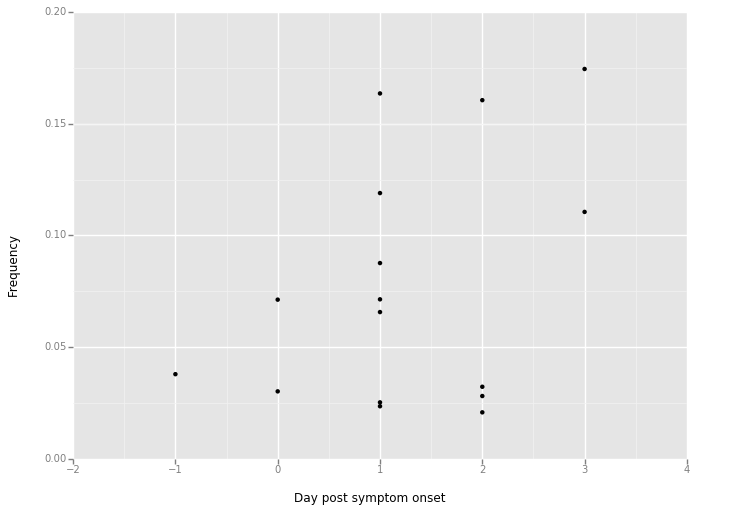

<ggplot: (282797965)>

In [24]:
ggplot(aes(x='DPI', y='freq.var'), data=AA) +\
    geom_point()  + ylab("Frequency")+xlab("Day post symptom onset")

In [25]:
AA_nonsynom_n=len(AA)
print(AA_nonsynom_n)
write_to_summary("Antigenic iSNV n:",AA_nonsynom_n)

16


In [26]:
HA_nonsyn_n=len(HA_nonsyn)
write_to_summary("NS HA n:",HA_nonsyn_n)
#HA_nonsyn_n

In [27]:
frac_isnv = "Proportion of snv in antigenic sites %f - %f" % (len(AA)/len(snv), (len(AA.loc[AA["Source"]=="Wiley"])+len(AA.loc[AA["Source"]=="Smith"])+len(AA.loc[AA["Source"]=="Caton"]))/len(snv))

print(frac_isnv)

better = AA.loc[(AA["Source"]=="Wiley")|(AA["Source"]=="Smith")|(AA["Source"]=="Caton")]
frac_infection = "Propotion of infections with antigenic sites %f - %f " % (len(AA.ENROLLID.unique())/200,len(better.ENROLLID.unique())/200)


print(frac_infection)

write_to_summary("Antigenic iSNV %:",frac_isnv)
write_to_summary("Antigenic infection n:",frac_infection)
#len(AA)/len(snv.loc[snv["class_factor"]=="Nonsynonymous"])


Proportion of snv in antigenic sites 0.027634 - 0.010363
Propotion of infections with antigenic sites 0.070000 - 0.030000 


## Amino acids for Nextflu


This a little old code but it used regex to get the amino acid position and and the variant or ref amino acid.

H3_name is the minor
H3_name_major is the major amino acid.

In [28]:
import re
H3=[]
H1=[]
H3_major= []
H1_major = []
pat = re.compile('\w(\d+) (in|of) (HA\d)') 
for index, row in HA_nonsyn.iterrows():
    H3_pos = pat.match(row.loc["PDB_4HMG"])
    H1_pos = pat.match(row.loc["PDB_4JTV"])
    var = row.loc["Var_AA"].split("'")[1]
    ref = row.loc["Ref_AA"].split("'")[1]
    if H3_pos:
        H3.append(H3_pos.group(3)+":"+H3_pos.group(1)+var)
        H3_major.append(H3_pos.group(3)+":"+H3_pos.group(1)+ref)
    else:
        H3.append("-")
        H3_major.append("-")
    if H1_pos:
        H1.append(H1_pos.group(3)+":"+H1_pos.group(1)+var)
        H1_major.append(H1_pos.group(3)+":"+H1_pos.group(1)+ref)
    else:
        H1.append("-")
        H1_major.append("-")
        
        
HA_nonsyn["H3_name"] = H3
HA_nonsyn["H3_name_major"] = H3_major


HA_nonsyn["H1_name"] = H1
HA_nonsyn["H1_name_major"] = H1_major



/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [29]:

HA_nonsyn.to_csv("../data/processed/secondary/minor_nonsynom.csv")

# Is  AA_pos  base 0 or base 1

I expect a G at PB1 594 (base1) )(593-base 0)  in sample MH7800 HK_8

In [ ]:
for seq_record in SeqIO.parse("../data/processed/HK_8/coding_fa/MH7800_A.removed.parsed.coding.fasta", "fasta"):    
        if seq_record.name == "PB1":
            PB1=seq_record
            PB1_prot = seq_record.seq.translate(to_stop=True)
        if seq_record.name == "NR":
            NR=seq_record
            NR_prot = seq_record.seq.translate(to_stop=True)

In [ ]:
PB1_prot

In [ ]:
PB1_prot[593]

In [ ]:
NR_prot[160]

It is is base 1.